In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from NPw_aux import prepare_ion_data
import warnings
import os
warnings.filterwarnings("ignore")
import logging
datapath = os.environ.get("DATA_PATH")
if datapath == None:
    raise KeyError("Enviromental variable data path has to be declared")
print(datapath)
from datetime import datetime, timedelta
freq = timedelta(minutes=30)
logging.disable(logging.CRITICAL)

/home/carloscano/data/


In [2]:
#df_GNSSTEC,df_covariate, df_eq = prepare_ion_data(datapath, "GRK", freq)

In [3]:
#df_GNSSTEC.to_pickle("df_GNSSTEC.pkl")
#df_covariate.to_pickle("df_covariate.pkl")
#df_eq.to_pickle("df_eq.pkl")

In [4]:
import pandas as pd
df_GNSSTEC = pd.read_pickle("../data_test/df_GNSSTEC.pkl")
df_covariate = pd.read_pickle("../data_test/df_covariate.pkl")
df_eq = pd.read_pickle("../data_test/df_eq.pkl")
n_forecasts = 48


In [5]:
%matplotlib inline
from aux_function_SR import read_data, get_eq_filtered, SR_SENSORS
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level, save, load
import logging
import pandas as pd

import pickle
from NPw import NPw, ConfigEQ, ConfigNPw, ConfigForecast
from dataclasses import dataclass, asdict
from dateutil.relativedelta import *

import ast

import sys
import dateutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler,MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

from NPw import NPw

import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from NPw_aux import prepare_EQ, ConfigEQ


In [6]:

ConfigEQ_d = {
    "dist_start": 1000,
    "dist_delta": 3000,
    "mag_start": 4.5,
    "mag_delta": 2,
    "filter": 1,
    "drop": ["arc_cos", "arc_sin"],
}
config_events = ConfigEQ(**ConfigEQ_d)

df_regressor = df_GNSSTEC.reset_index()
df_other = df_covariate
df_events = prepare_EQ(df_eq, config_events)    
 
forecast_length = timedelta(hours=24)
question_mark_length = timedelta(hours=24)
# Time to take into account to predict 
historic_lenght =  timedelta(days=5)
training_lenght = timedelta(days=30)

65884
1778


In [7]:
from darts import TimeSeries

In [8]:
from DartsFCeV import NLinearDartsFCeVConfig,TransformerDartsFCeVConfig, DartsFCeVConfig,NHITSDartsFCeVConfig, NBEATSDartsFCeVConfig,RNNDartsFCeVConfig,TCNDartsFCeVConfig, TFTDartsFCeVConfig

from FCeV import FCeV, FCeVConfig

TCN_darts_FCeV_config = {
"dilation_base": 2,
"weight_norm": True,
#"kernel_size": 16,
#"num_filter": 1000
}


RNN_darts_FCeV_config = {
     "RNNmodel": "RNN"
}
RNN_darts_FCeV_config = RNNDartsFCeVConfig(**RNN_darts_FCeV_config)

NBEATS_darts_FCeV_config = {
    "num_stacks": 10,
    #"num_layers": 10,
    "num_blocks": 10,
    #"layer_widths": 10,
    "expansion_coefficient_dim": 10
}
Transformer_darts_FCeV_config = {
    #"d_model": 12,
    "n_head_divisor": 3,
    #"num_encoder_layers": 3,
    #"num_decoder_layers": 3,
    "dim_feedforward": 16
}


NHITS_darts_FCeV_config = {
    "num_stacks": 10,
    #"num_layers": 10,
    "num_blocks": 10,
    #"layer_widths": 10,
    "expansion_coefficient_dim": 10,
    "max_pool_1d": True
}

TFT_darts_FCeV_config = {
    #"lstm_layers" : 2,
    #"hidden_size" : 64,
    "num_attention_heads" : 4,
    "full_attention" : False,
    "add_relative_index": False,
    "hidden_continuous_size" : 8,
}
TFT_darts_FCeV_config = TFTDartsFCeVConfig(**TFT_darts_FCeV_config)


NLinear_darts_FCeV_config = {
"const_init": True,
}
TCN_darts_FCeV_config = TCNDartsFCeVConfig(**TCN_darts_FCeV_config)



NBEATS_darts_FCeV_config = NBEATSDartsFCeVConfig(**NBEATS_darts_FCeV_config)

NHITS_darts_FCeV_config = NHITSDartsFCeVConfig(**NHITS_darts_FCeV_config)

Transformer_darts_FCeV_config = TransformerDartsFCeVConfig(**Transformer_darts_FCeV_config)

NLinear_darts_FCeV_config = NLinearDartsFCeVConfig(**NLinear_darts_FCeV_config)


darts_FCev_config = {
    "DartsModelConfig": RNN_darts_FCeV_config,
    "dropout":0.2,
    "n_epochs":300,
    "n_layers": 1,
    "internal_size": 16,
    "batch_size":1200 ,
    "learning_rate": 1e-3,
    "use_gpu": True,
    "event_type": "Non-Binary",
    "patience":15,
    "seed": 1234567,
    "probabilistic": True,
    "config_synthetic": "constant"
}
darts_FCeV_config = DartsFCeVConfig(**darts_FCev_config)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
train_day = datetime.fromisoformat("2018-10-01T00:00:00")
val_day = datetime.fromisoformat("2019-01-01T00:00:00")
forecast_length = timedelta(hours=24)
question_mark_length = timedelta(hours=24)
# Time to take into account to predict 
historic_lenght =  timedelta(days=5)
training_lenght = timedelta(days=38)
freq = pd.Timedelta(minutes=30)

FCev_config = {
    "freq": freq,
    "forecast_length": forecast_length,
    "question_mark_length": question_mark_length,
    "training_length": training_lenght,
    "verbose": True,
    "input_length": historic_lenght
}


FCev_config = FCeVConfig(**FCev_config)

In [10]:
#synthetic_events = pd.read_pickle("../data_test/synthetic.pkl")
#df_synth = prepare_EQ(synthetic_events, config_events)  
output_path = "results/"
synthetic_events = df_covariate[["f107"]].quantile([.1,0.25, .5,0.75, .9])#.drop(["count", "std"])
synthetic_events = pd.DataFrame([68., 70., 72., 74., 76., 78., 80.], columns= ["f107"])
df_events = pd.DataFrame(df_covariate["f107"])

current_fcev = FCeV(FCev_config, darts_FCeV_config, df_GNSSTEC, df_covariate.drop("f107", axis = 1),df_events,  output_path, synthetic_events)

In [11]:
synthetic_events = pd.DataFrame([68., 70., 72., 74., 76., 78., 80.], columns= ["f107"])
synthetic_events

,f107
0,68.0
1,70.0
2,72.0
3,74.0
4,76.0
5,78.0
6,80.0


In [12]:
current_fcev.create_folds(pd.Timestamp(2018,1,1,10), 12)
print(current_fcev.folds.iloc[7])
from darts import TimeSeries

2016-01-01 00:00:00
start_date   2019-09-29 14:30:00
end_date     2019-11-06 14:30:00
Name: 7, dtype: datetime64[ns]


In [13]:

iteration = 7
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(3600)
def train_with_timeout(fcev_instance, iteration):
    df_fore = current_fcev.process_fold(iteration)
    return df_fore

In [14]:
try:
    df_fore = train_with_timeout(current_fcev, iteration)
except FunctionTimedOut: 
    print(np.nan)
    #sys.exit(0)
    #Missing covariates; could not find past covariates in index value range: 2019-11-02 14:30:00 - 2019-11-04 14:00:00.

train start: 2019-09-29 15:00:00 end: 2019-11-05 14:00:00 - val start: 2019-11-05 14:30:00 val end: 2019-11-06 14:00:00


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [102]:
df_main = df_fore["BASE"]
from FCeV import METRICS
current_ts = TimeSeries.from_dataframe(df_main["current"])
all_ts_base = current_fcev.FCeV_model.input_series.drop_after(current_ts.start_time())
all_ts_base = all_ts_base.append(current_ts)
all_ts_real, _ = current_fcev.FCeV_model.input_series.split_after(current_ts.end_time())

7.065012


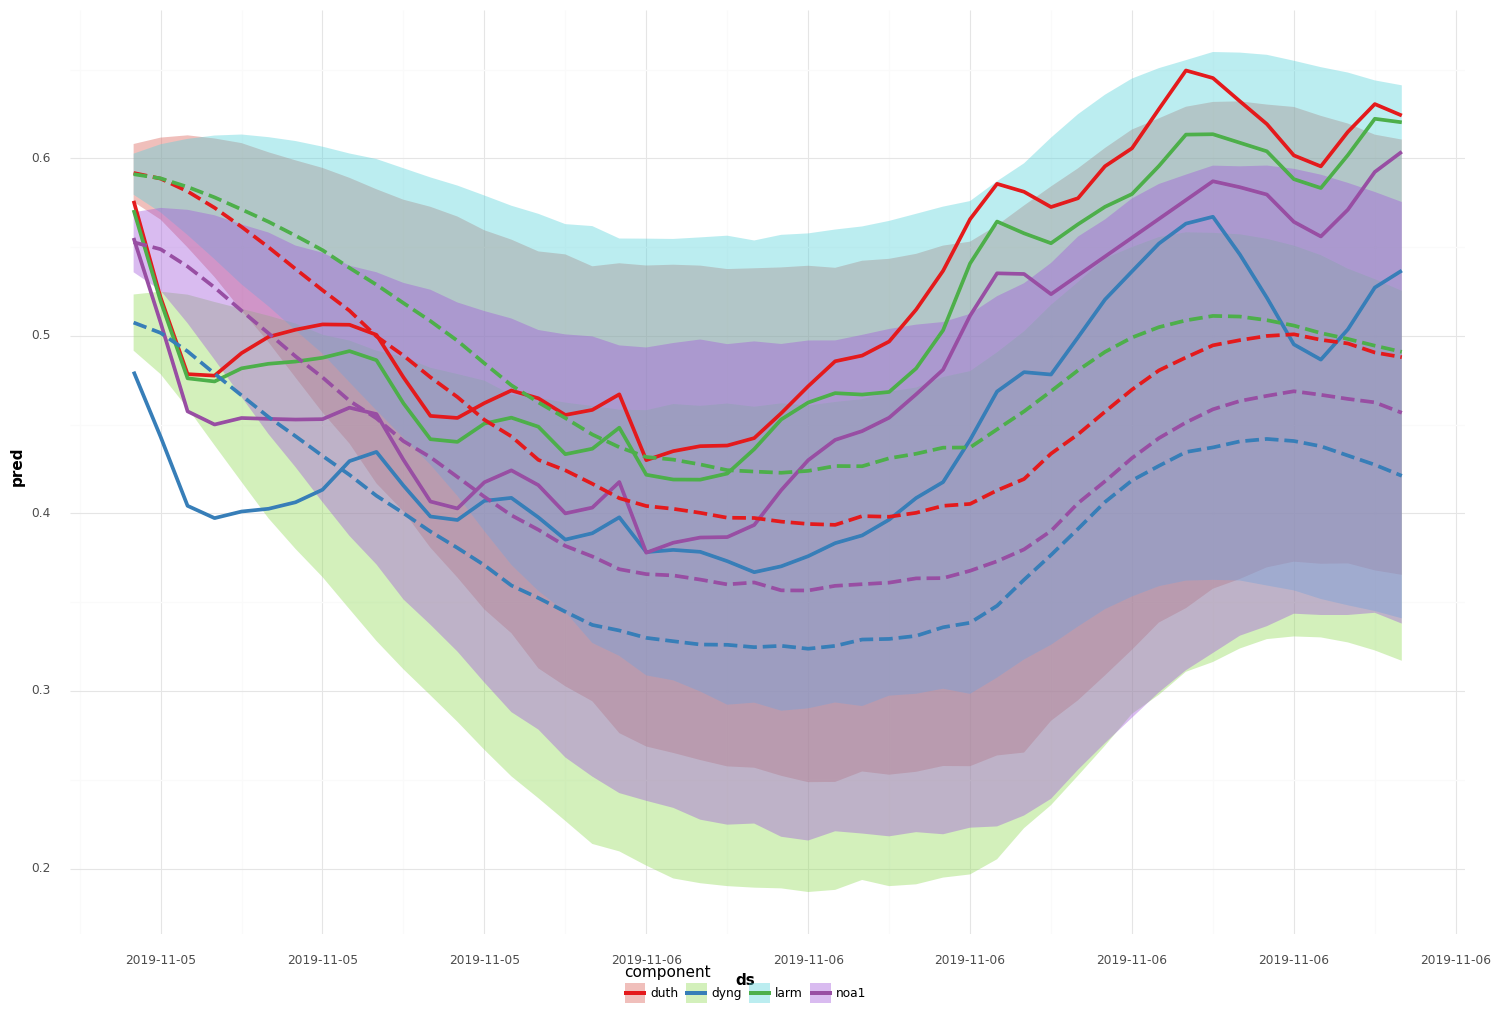

<ggplot: (8743134633400)>

In [18]:
from FCeV import METRICS
df_main = df_fore["EMPTY"]
print(current_fcev.get_metrics_from_fc(df_main, METRICS.RMSE).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

9.0875635


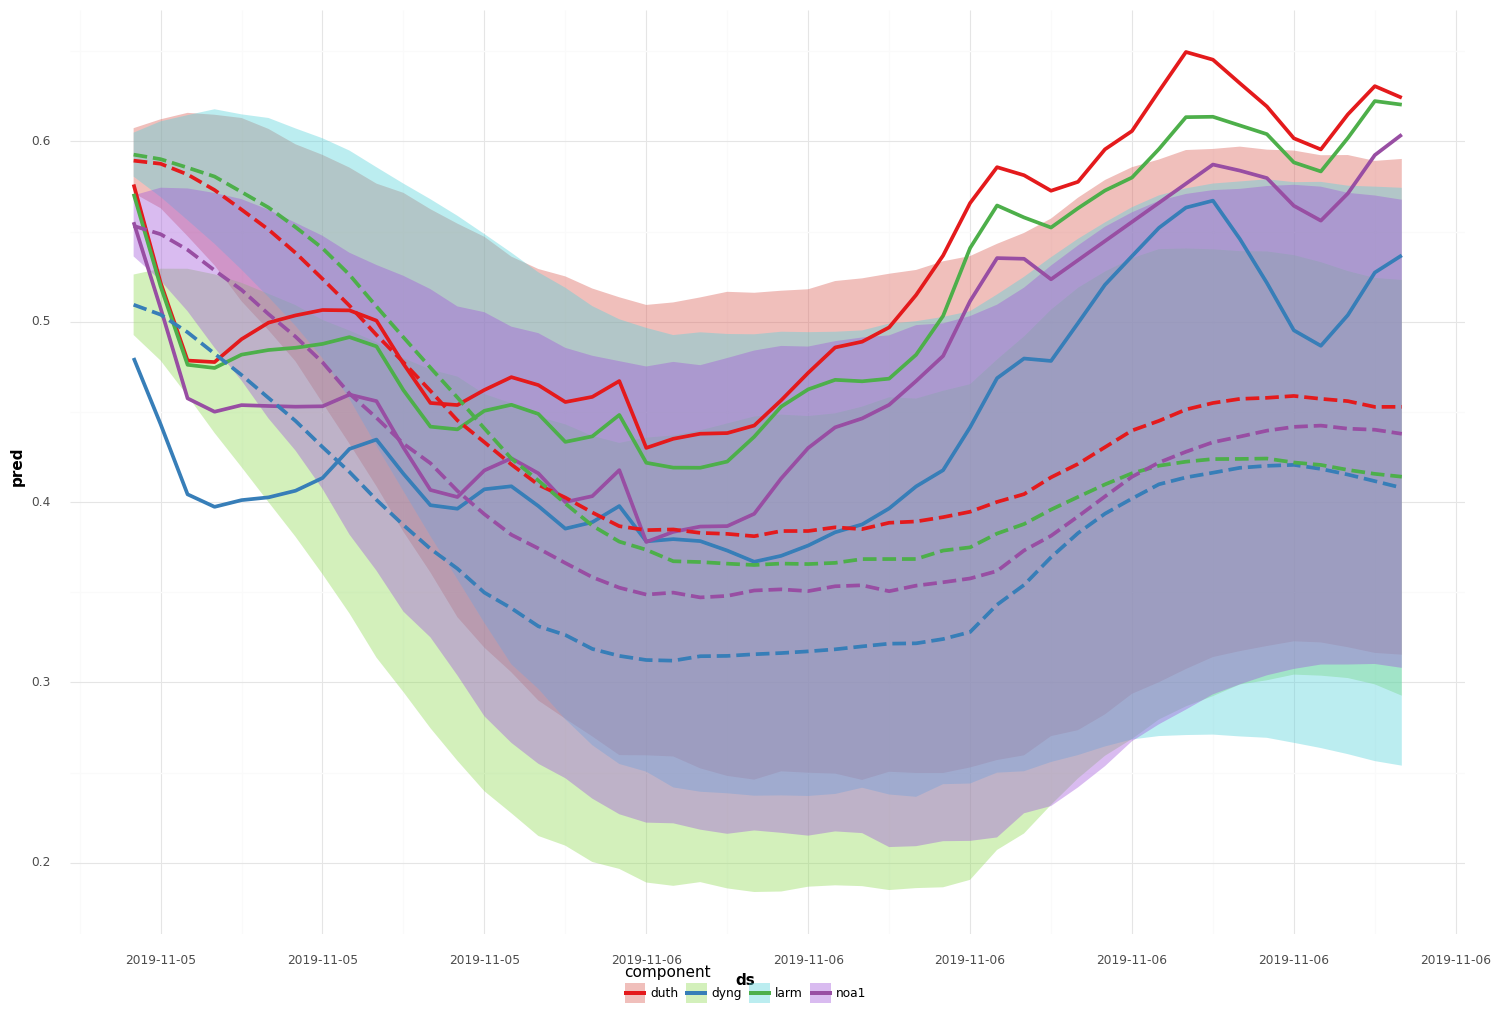

<ggplot: (8743212265177)>

In [17]:
df_main = df_fore["BASE"]
print(current_fcev.get_metrics_from_fc(df_main, METRICS.RMSE).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

In [105]:
len(all_ts_real)

67469

In [106]:
real = current_fcev.FCeV_model.input_series

In [107]:
iterations = current_fcev.iterations

In [ ]:
values = current_fcev.FCeV_model.model.predict(n=48, num_samples=1000).plot()


In [ ]:
day = iterations.iloc[iteration].end_date

In [ ]:
real.slice(day - pd.Timedelta(days = 4), day).plot()

## SALES EXAMPLE

In [ ]:
datapath_sales = "/home/carloscano/data/kaggle/store-sales-time-series-forecasting/"

In [ ]:
df_train =  pd.read_csv(datapath_sales + "train.csv", parse_dates=["date"]).rename(columns = {"date":"ds"})
df_test =  pd.read_csv(datapath_sales + "test.csv", parse_dates=["date"]).rename(columns = {"date":"ds"})


In [ ]:
df_test["ds"]

In [ ]:
df_train["family"].unique()

In [ ]:
df_train["store_nbr"].max()

#AUTOMOTIVE - 11

#Electronics index: 47 - 

import time
for i in range(1, 55):
    df_train_selected = df_train[(df_train["store_nbr"] == i) &(df_train["family"] == "BOOKS") ]
    df_train_selected = df_train_selected.reset_index().drop(["store_nbr", 'family', "id", "index"], axis = 1).set_index("date")
    total_prom = np.sum(df_train_selected["onpromotion"] > 0)
    total_value = np.sum(df_train_selected["onpromotion"])
    print(f"index: {i} - {total_value} / {total_prom}")

In [ ]:
df_train_selected = df_train[(df_train["store_nbr"] == 54) & ((df_train["family"] == "AUTOMOTIVE")) ]
df_train_selected = df_train_selected.reset_index().drop(["store_nbr", 'family', "id", "index"], axis = 1).set_index("ds")
df_signal = df_train_selected.drop("onpromotion", axis =1) #["sales"]
df_events = df_train_selected[df_train_selected["onpromotion"] > 0].drop("sales", axis = 1)
df_events["onpromotion"] = (df_events["onpromotion"] > 0)
df_events["onpromotion"] = 1

In [ ]:
df_cov1 = df_train[(df_train["store_nbr"] == 54) & ((df_train["family"] == "BREAD/BAKERY")) ]
df_cov1 = df_cov1.reset_index().drop(["store_nbr", 'family', "id", "index", "onpromotion"], axis = 1).set_index("ds")
df_cov2 = df_train[(df_train["store_nbr"] == 1) & ((df_train["family"] == "AUTOMOTIVE")) ]
df_cov2= df_cov2.reset_index().drop(["store_nbr", 'family', "id", "index", "onpromotion"], axis = 1).set_index("ds")

df_covariates = pd.concat([df_cov1, df_cov2], axis = 1)
df_covariates.columns =  ["bread_54", "auto_1"]

In [ ]:
from DartsFCeV import NLinearDartsFCeVConfig,TransformerDartsFCeVConfig, DartsFCeVConfig,NHITSDartsFCeVConfig, NBEATSDartsFCeVConfig,RNNDartsFCeVConfig,TCNDartsFCeVConfig, TFTDartsFCeVConfig

from FCeV import FCeV, FCeVConfig

TCN_darts_FCeV_config = {
"dilation_base": 2,
"weight_norm": True,
#"kernel_size": 16,
#"num_filter": 10
}
TCN_darts_FCeV_config = TCNDartsFCeVConfig(**TCN_darts_FCeV_config)
RNN_darts_FCeV_config = {
     "RNNmodel": "GRU"
}

RNN_darts_FCeV_config = RNNDartsFCeVConfig(**RNN_darts_FCeV_config)

TFT_darts_FCeV_config = {
    #"lstm_layers" : 2,
    #"hidden_size" : 64,
    "num_attention_heads" : 6,
    "full_attention" : False,
    "add_relative_index": False,
    "hidden_continuous_size" : 2,
}
TFT_darts_FCeV_config = TFTDartsFCeVConfig(**TFT_darts_FCeV_config)



darts_FCev_config = {
    "DartsModelConfig": RNN_darts_FCeV_config,
    "dropout":0.1,
    "n_epochs":1000,
    "n_layers": 1,
    "internal_size": 28,
    "batch_size":600 ,
    "learning_rate": 1e-2,
    "use_gpu": True,
    "event_type": "Non-Binary",
    "patience":30,
    "seed": 1234567,
    "probabilistic": True
}

darts_FCeV_config = DartsFCeVConfig(**darts_FCev_config)
forecast_length = timedelta(hours=24 * 3)
question_mark_length = timedelta(hours=24 * 3)
# Time to take into account to predict 
historic_lenght =  timedelta(days=32)
training_lenght = timedelta(days=798)
freq = pd.Timedelta(days=1)

FCev_config = {
    "freq": freq,
    "forecast_length": forecast_length,
    "question_mark_length": question_mark_length,
    "training_length": training_lenght,
    "verbose": False,
    "input_length": historic_lenght
}

FCev_config = FCeVConfig(**FCev_config)

In [ ]:
df_synth = pd.DataFrame([1], columns = ["onpromotion"])

In [ ]:
os.getcwd()

In [12]:
import datetime
output_path = "/home/carloscano/outputs/RNN_best_2019/"
#current_fcev = FCeV(FCev_config, darts_FCeV_config, df_signal, df_covariates,df_events,  output_path, df_synth)


In [13]:
all_dict = current_fcev.read_result(output_path)

In [19]:
from darts.ad import KMeansScorer, WassersteinScorer, CauchyNLLScorer
def get_anom(df):
    all_anom_score = None
    for index in range(5):
        ts_current_val = TimeSeries.from_dataframe(df["current"])
        ts_base_val = TimeSeries.from_dataframe(df["pred"])
        ts_current_train = current_fcev.FCeV_model.input_series.drop_after(ts_current_val.start_time())
        ts_base_train = current_fcev.FCeV_model.input_series.drop_after(ts_base_val.start_time())
        ts_current_all = ts_current_train.append(ts_current_val)
        ts_base_all = ts_base_train.append(ts_base_val)
        scorer = KMeansScorer(k=10, window=48)
        scorer.fit_from_prediction(ts_current_train, ts_base_train)
        anom_score = scorer.score_from_prediction(ts_current_val, ts_base_val)
        if all_anom_score is None:
            all_anom_score = anom_score
        else:
            all_anom_score = all_anom_score.concatenate(anom_score, axis = "component")
    return all_anom_score.mean(1).pd_dataframe()

In [20]:
all_dict = df_fore

In [21]:
anom_serie = None
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = value
        df = get_anom(df)
        df.columns = [f"{key}"]
        if anom_serie is None:
            anom_serie = TimeSeries.from_dataframe(df)
        else:
            anom_serie = anom_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")
    else:
        for key_inner, value_inner in value.items():
            df = get_anom(value_inner)
            df.columns = [f"{key}_{key_inner}"]
            anom_serie = anom_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")

In [ ]:
#val_events = current_fcev.FCeV_model.events.slice_intersect(anom_serie)["pr"]
anom_serie = anom_serie.concatenate(val_events, axis= "component")

In [23]:
synthetic_events

,f107
0,68.0
1,70.0
2,72.0
3,74.0
4,76.0
5,78.0
6,80.0


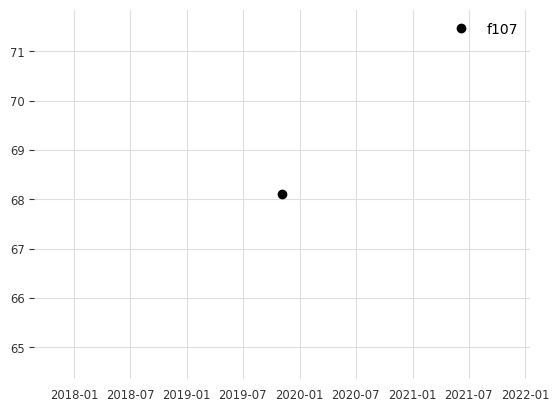

In [24]:
current_fcev.FCeV_model.events.slice_intersect(anom_serie).plot()

In [25]:
anom_serie.pd_dataframe().mean()

component
BASE     1.472074
EMPTY    1.154213
0_0      1.546562
1_1      1.668849
2_2      1.680898
3_3      1.668320
4_4      1.726097
5_5      1.726243
6_6      1.676881
dtype: float64

In [116]:
next_slice = anom_serie
start_point = anom_serie.start_time()
chunks = list()
chunk_len = 10
total_len = len(anom_serie)
for index in range(total_len // chunk_len  - 1) :
    current_slice, next_slice = next_slice.split_before(chunk_len)
    start_point = current_slice.end_time()
    chunks.append(current_slice.pd_dataframe())

## USING TAB FASTAI

In [ ]:
from fastai.tabular.all import *

In [ ]:

df["pr"] = df["pr"] > 1
y_name = "pr"

In [ ]:
splits = RandomSplitter(valid_pct=0.33)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cont_names = list(df.drop(y_name,axis = 1).columns.values),
                   y_names=y_name,
                   y_block = CategoryBlock(),
                   splits=splits)

In [ ]:
dls = to.dataloaders(bs=100)
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(5)
learn.show_results()

## Using Pythorch Lightning

In [33]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
from torch import nn
from torch.utils.data import Dataset ,DataLoader
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torcheval.metrics import BinaryAccuracy
from torchmetrics.classification import BinaryAccuracy
import torchmetrics
channels = len(chunks[1].columns) - 1
CLASSES = 2
input_length = 10
kernel_size = 3

In [59]:
class CassavaModel(pl.LightningModule):
    def __init__(self):
      #image_size = 64
        super().__init__()
        self.cnv = nn.Conv1d(channels,64,kernel_size)
        self.rel = nn.ReLU()
        self.bn = nn.BatchNorm1d(64)
        self.mxpool = nn.MaxPool1d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(4 * 64,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,1)
        self.softmax = nn.Softmax()
        self.accuracy = BinaryAccuracy()

    def forward(self,x):
        out = self.bn(self.rel(self.cnv(x)))
        out = self.flat(self.mxpool(out))
        out = self.rel(self.fc1(out))
        out = self.rel(self.fc2(out))
        out = self.fc3(out)
        return out

    def loss_fn(self,out,target):
        print(f"EVAL: out {out.view(-1).shape}, img {target.shape}")
        return torch.nn.BCEWithLogitsLoss()(out.view(-1),target)
    
    def configure_optimizers(self):
        LR = 1e-3
        optimizer = torch.optim.AdamW(self.parameters(),lr=LR)
        return optimizer

    def training_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        
        loss = self.loss_fn(out,label)
        self.log('train_loss', loss)
        return loss       

    def validation_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        print(label)
        loss = self.loss_fn(out,label)
        logits = torch.round(nn.Sigmoid()(out))
        print(logits)
        accu = self.accuracy(logits, label.to(dtype=int))     
        print(f"VAL: out {out.shape}, img {img.shape}")
        self.log('valid_loss', loss)
        self.log('train_acc_step', accu)
        return loss, accu

In [60]:
class CassavaDataset(Dataset):
    def __init__(self,list_of_df):

        self.list_of_df = list_of_df


    def __len__(self):
        return len(self.list_of_df)
    
    def __getitem__(self,item):
        current_df = self.list_of_df[item]
        x = current_df.drop("pr", axis = 1).to_numpy()
        y = np.any(current_df["pr"] > 0)

        return {
            "x":torch.tensor(x,dtype=torch.float),
            "y":torch.tensor(y,dtype=torch.float),
        } 

In [61]:
class CassavaLightDataset(pl.LightningDataModule):
    def __init__(self,batch_size=10):
        super().__init__()
        self.batch_size = batch_size
    
    def setup(self,stage=None):
        train, test = train_test_split(chunks, test_size = 0.2)
        self.train_dataset = CassavaDataset(train)
        self.validation_dataset = CassavaDataset(test)

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset,
                            batch_size=self.batch_size,
                            shuffle=True)
        return train_loader
    def val_dataloader(self):
        valid_loader = DataLoader(self.validation_dataset,
                            batch_size=self.batch_size,
                            shuffle=False)       
        return valid_loader

In [62]:
torch.cuda.empty_cache()
del mod
del dx

In [63]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_loss',
    dirpath='./',
    filename='models-{epoch:02d}-{valid_loss:.2f}',
    save_top_k=3,
    mode='min') 

mod = CassavaModel()
dx = CassavaLightDataset()
trainer = pl.Trainer(gpus=-1,max_epochs=6,callbacks=[checkpoint_callback])
trainer.fit(model=mod,datamodule=dx) 

Sanity Checking: 0it [00:00, ?it/s]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
EVAL: out torch.Size([10]), img torch.Size([10])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


TypeError: 'BinaryAccuracy' object is not callable

1.13.1+cu117


In [ ]:
current_series

In [ ]:
anom_serie.columns = ["NO"]

In [ ]:
from darts import TimeSeries
current_fcev = FCeV(FCev_config, darts_FCeV_config, df_signal, df_covariates,df_events,  output_path, df_synth)
    
iteration = 0
date_start = pd.Timestamp(2017, 1, 1)
current_fcev.create_folds(date_start, 12)
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(3600)
def train_with_timeout(fcev_instance, iteration):
    df_fore = current_fcev.process_fold(iteration)
    return df_fore
try:
    df_fore = train_with_timeout(current_fcev, iteration)
except FunctionTimedOut: 
    print(np.nan)

In [ ]:
df_fore["SYNTH_0"].keys()




In [ ]:
df_main = df_fore["BASE"]
df_synth_1 = df_fore["SYNTH_0"]["1"]
df_synth_3 = df_fore["SYNTH_0"]["3"]
df_synth_5 = df_fore["SYNTH_0"]["5"]
df_synth_6 = df_fore["SYNTH_0"]["6"]
df_synth_8 = df_fore["SYNTH_0"]["8"]
df_real = current_fcev.FCeV_model.input_series.pd_dataframe()

In [ ]:
import matplotlib.pyplot as plt
df_main = df_fore["BASE"]
df_synth_0 = df_fore["SYNTH_0"]["0"]
df_synth_1 = df_fore["SYNTH_0"]["1"]
df_synth_2 = df_fore["SYNTH_0"]["2"]
#ts_base_val.plot()
(get_anom(df_main)).plot(label="No event", c="orangered", lw=3)
#(get_anom(df_real)).plot(label="Real", c="red", lw=3)
(get_anom(df_synth_0)).plot(label="0 days after", c="blue", lw=3)
(get_anom(df_synth_1)).plot(label="1 days after", c="green", lw=3)
(get_anom(df_synth_2)).plot(label="2 days after", c="cyan", lw=3)

In [ ]:
TimeSeries.from_dataframe(main_df["pred"])

In [ ]:
from FCeV import METRICS
main_df = df_fore["BASE"]
#second_df = df_fore["SYNTH_0"]["5"]
print(current_fcev.get_metrics_from_fc(main_df, METRICS.RMSE).mean().mean())
print(current_fcev.get_metrics_from_fc(second_df, METRICS.RMSE).mean().mean())

In [33]:
main_df = df_fore["BASE"]

In [38]:
main_df.stack(level=1).reset_index(1).columns

Index(['component', 'current', 'pred', 'uncer'], dtype='object')

In [45]:
second_df= main_df.stack(level=1).reset_index(1)

In [46]:
second_df["uncer_min"] = second_df['pred'] - second_df['uncer']
second_df["uncer_max"] = second_df['pred'] + second_df['uncer']

second_df["uncer_min"] = second_df['pred'] 
second_df["uncer_max"] = second_df['pred']

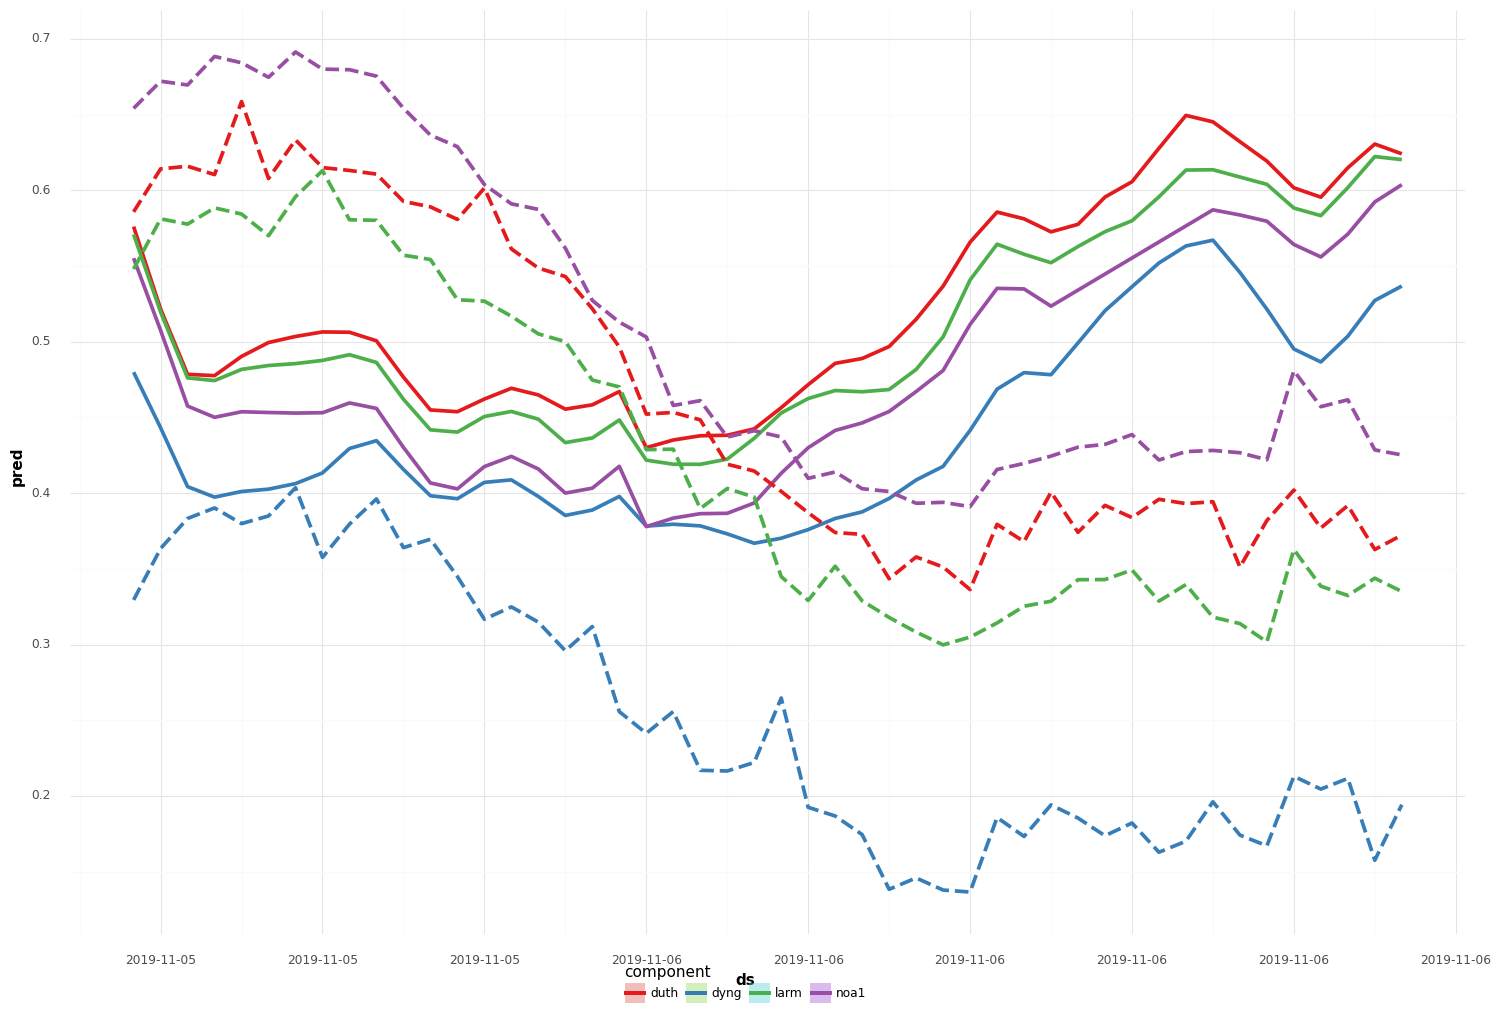

<ggplot: (8777135095336)>

In [47]:
from plotnine import ggplot, aes, facet_grid, labs, geom_line,geom_point, theme, geom_ribbon,theme_minimal,scale_color_brewer
from plotnine_prism import *
(
    ggplot(second_df.reset_index())  # What data to use
    + aes(x="ds")  # What variable to use
    + geom_ribbon(aes(y = "pred", ymin = "uncer_min", ymax = "uncer_max", fill = "component"), alpha = .4) 
    + geom_line(aes(y="current", color = "component"),size = 1.5)  # Geometric object to use for drawing
    + geom_line(aes(y="pred", color = "component"),linetype="dashed",size = 1.5 )  # Geometric object to use for drawing
    + theme_minimal() 
    +theme(legend_position="bottom", figure_size=(18, 12))
    + scale_color_brewer(type="qual", palette="Set1")
)

In [ ]:
from FCeV import METRICS
current_fcev.get_metrics_from_fc(df_fore["BASE"], METRICS.RMSE).mean().mean()

In [ ]:
current_fcev.get_metrics_from_fc(df_fore["SYNTH_2"]["8"], METRICS.RMSE).mean().mean()

In [ ]:
df_fore["BASE"].plot()

In [ ]:
df_fore["SYNTH_5"]["24"].plot()

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
train_day = dateutil.parser.parse("2018-09-30")
val_day = dateutil.parser.parse("2018-12-31")
series = TimeSeries.from_dataframe(df_ion[df_ion.index < val_day], fill_missing_dates=False, freq=freq)
series = series.astype(np.float32)
filler = MissingValuesFiller()
tec_series = filler.transform(series, method = "from_derivatives")

# Create training and validation sets:
train_tec, val_tec = tec_series.split_after(pd.Timestamp(train_day))

# We'll use the month as a covariate
scaler_tec = Scaler()
train_tec = scaler_tec.fit_transform(train_tec)
val_tec = scaler_tec.transform(val_tec)
tec_series = scaler_tec.transform(tec_series)



In [ ]:
widths = [4, 4, 3, 3, 6, 6, 6 ,6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 5, 7, 3, 4, 6, 4, 6, 5, 6, 6, 6, 9, 9, 9, 9, 3]
ion_data = pd.read_fwf('/home/carloscano/data/ion/ionosphere_parameters_data.txt', widths = widths, header=None)
id_ion = ["year", "doy", "hour", "id imf", "B scalar", "B vector", "Lat B", "Long B", "BY", "Bz", "SW Plasma Ta", "SW Proton", "SW Plasma Speed", "SW Plasma flow long", "SW Plasma Speed lat", "Alpha ratio", "Flow pressure", "Alfen", "Magneto", "Quasy", "Kp", "N sunspot", "Dst-index", "Ap index", "f107", "AE", "AL", "AU", "pc", "lyman", "Proton10", "Proton30", "Proton60", "Flux" ]
ion_data.columns = id_ion
strfmt = "{year}-{doy:0=3d}T{hour:0=2d}:00:00"

ion_data["datetime"] = ion_data.apply(lambda x: datetime.strptime(strfmt.format(year = int(x["year"]), doy = int(x["doy"]), hour = int(x["hour"])),"%Y-%jT%H:%M:%S"), axis = 1)

ion_data = ion_data.drop(["year", "doy", "hour"], axis = 1).set_index("datetime")

ion_data = ion_data[["Kp", "f107", "N sunspot"]]

In [ ]:
df_input

In [ ]:

ion_ts = TimeSeries.from_dataframe(ion_data[ion_data.index < val_day], fill_missing_dates=True, freq = "1H").resample(freq=freq)
ion_ts = ion_ts.astype(np.float32)
scaler_ion = Scaler()
ion_ts = scaler_ion.fit_transform(ion_ts)
# Create training and validation sets:
train_ion, val_ion = ion_ts.split_after(pd.Timestamp(train_day))

In [ ]:
my_model_TCN = TCNModel(
    input_chunk_length=48*5,
    output_chunk_length=48,
    n_epochs=40,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,    
    log_tensorboard=True,
     force_reset=True,
        pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },

)

my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Ion_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

In [ ]:
%%time

my_model_TCN.fit(
    train_tec,
    past_covariates=ion_ts,
    verbose=True,
)

In [ ]:
my_model_TCN.predict(100, past_covariates=ion_ts).plot()

In [ ]:
my_model_TCN.predict(10)

In [ ]:
from darts.ad import KMeansScorer,ForecastingAnomalyModel
scorer = KMeansScorer(k=5, window=20)

In [ ]:
ad_model = ForecastingAnomalyModel(my_model_TCN, scorer)
scorer.fit(train_tec)

In [ ]:
#anom_score = ad_model.score(val_tec,    past_covariates=ion_ts)

In [ ]:
%%time
ad_model.show_anomalies(val_tec,    past_covariates=ion_ts)

In [ ]:
train_tec.plot()

In [ ]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train_tec))
binary_anom = detector.detect(anom_score)

In [ ]:
import matplotlib.pyplot as plt

series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

In [ ]:
# Scale so that the largest value is 1.
# This way of scaling perserves the sMAPE
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [ ]:
for i in [10, 50, 100, 150, 250, 350]:
    plt.figure(figsize=(15, 5))
    all_series_fp32[i].plot(label="{}".format(i, lw=1))

In [ ]:
from darts.explainability.shap_explainer import ShapExplainer
from darts.models import RegressionModel

In [ ]:
model = RegressionModel(lags=24, lags_future_covariates = [24,24], output_chunk_length = 24)
model.fit(train_tec, future_covariates=ion_ts)

## DALEX

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (25, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 48 * 5
forecast_horizon = 48
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=1000,
    n_epochs=2,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
            pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)


In [ ]:
my_model.fit(train_tec, future_covariates=ion_ts, verbose=True)

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


In [ ]:
eval_model(my_model, 48, tec_series, val_ion)

In [ ]:
forecast_horizon = 48
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

In [ ]:
eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon * 10,
    start=training_cutoff,
    transformer=transformer,
)

In [ ]:
my_model = TCNModel(
    input_chunk_length=48*5,
    output_chunk_length=24,
    n_epochs=2,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,    
    log_tensorboard=True,
     force_reset=True,

)

In [ ]:
def retrain_func(pred_time, train_series, past_covariates, future_covariates):
    print(len(past_covariates))
    return True

In [ ]:
backtest = model_air.historical_forecasts(
    series=tec_filled,
    past_covariates=ion_ts,
    start=0.90,
    forecast_horizon=1,
    retrain=False,
    verbose=False,
    last_points_only = False,
)

In [ ]:
def plot_backtest(ts_actual, ts_backtest):
    ts_actual[ts_backtest.time_index].plot(label="actual")
    ts_backtest.plot(label="backtest (H=6)")
    plt.legend()


In [ ]:
plot_backtest(tec_filled, backtest[5])

In [ ]:
len(filled)*0.01

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.datasets import AirPassengersDataset

In [ ]:
# Read data:
series = AirPassengersDataset().load()
series = series.astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [ ]:
my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)
my_model.fit(train_transformed, val_series=val_transformed)